In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Cargar el dataset
file_path = 'dataset/decepal.csv'
data = pd.read_csv(file_path, delimiter=';')

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73180/2906498877.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, delimiter=';')


In [3]:
data.shape 

(296822, 30)

In [4]:

# Convertir columnas de fechas a objetos datetime
date_columns = ['FECHA_FACTURA', 'MAX_FECHA_COBRO', 'FECHA_CONTABILIZACION']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73180/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73180/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/xx/fj7dzt957rd1sg25bl4jv1b00000gn/T/ipykernel_73180/153277072.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [5]:
# Extraer características de las fechas
for col in date_columns:
    data[col + '_YEAR'] = data[col].dt.year
    data[col + '_MONTH'] = data[col].dt.month
    data[col + '_DAY'] = data[col].dt.day
    data[col + '_WEEKDAY'] = data[col].dt.weekday

In [6]:

# Eliminar las columnas originales de fecha si ya no son necesarias
data.drop(columns=date_columns, inplace=True)


In [7]:
columns_to_drop = ['EMPRESA', 'NUMERO_FACTURA', 'NUMERO_ASIENTO_BORRADOR', 'DIVISA', 'TIPO_FACTURA', 'DIARIO', 'IMPORTE_COBRADO_FRA', 'CUENTA_CONTABLE','NUM_EFECTOS_COBRADOS', 'NUM_EFECTOS_PARCIAL', 'NUM_EFECTOS_IMPAGADO', 'NUM_EFECTOS_FUERA_PLAZO', 'NUM_EFECTOS_PDTE_EN_PLAZO']
data.drop(columns=columns_to_drop, inplace=True)

In [8]:
# Convertir todas las entradas en las columnas categóricas a cadenas
categorical_columns = data.select_dtypes(include=['object']).columns
for column in categorical_columns:
    data[column] = data[column].astype(str)


In [9]:

# Convertir columnas categóricas a variables numéricas
label_encoders = {}
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [10]:

# Visualización inicial del dataset
print("Primeras filas del dataset:")
data.head()

Primeras filas del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,ENVIO_ELECTRONICO,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
0,2018,22,1,1111,3,33,0,53401,1,0,...,20,1,2018.0,4.0,30.0,0.0,2018,3,20,1
1,2018,22,1,1246,3,33,0,11901,1,0,...,20,1,2018.0,4.0,30.0,0.0,2018,3,20,1
2,2018,22,1,6041,3,6,0,42419,1,0,...,20,1,2018.0,4.0,30.0,0.0,2018,3,20,1
3,2018,22,1,2101,3,33,0,17084,1,0,...,20,1,2018.0,4.0,30.0,0.0,2018,3,20,1
4,2018,22,1,2202,3,47,0,52166,1,0,...,17,5,2018.0,7.0,30.0,0.0,2018,3,17,5


In [11]:
# Análisis Exploratorio de Datos (EDA)
# Resumen estadístico
print("\nResumen estadístico del dataset:")
data.describe()


Resumen estadístico del dataset:


,EJERCICIO,NUMERO_SERIE,ORGANIZACION_COMERCIAL,CLIENTE,MES_FACTURA,FORMA_COBRO,CENTRO_CONTABLE,LIQUIDO_FACTURA,ALBARAN_FACTURA,ENVIO_ELECTRONICO,...,FECHA_FACTURA_DAY,FECHA_FACTURA_WEEKDAY,MAX_FECHA_COBRO_YEAR,MAX_FECHA_COBRO_MONTH,MAX_FECHA_COBRO_DAY,MAX_FECHA_COBRO_WEEKDAY,FECHA_CONTABILIZACION_YEAR,FECHA_CONTABILIZACION_MONTH,FECHA_CONTABILIZACION_DAY,FECHA_CONTABILIZACION_WEEKDAY
count,296822.000000,296822.000000,296822.000000,296822.000000,296822.000000,296822.000000,296822.000000,296822.000000,296822.000000,296822.000000,...,296822.00000,296822.000000,65087.000000,65087.000000,65087.000000,65087.000000,296822.000000,296822.000000,296822.00000,296822.000000
mean,2020.455623,25.213060,6.276617,32395.471633,6.402928,29.062047,8.402234,34496.108287,0.983829,0.569601,...,17.43707,2.053244,2020.329052,6.673621,15.053421,2.088727,2020.455623,6.402928,17.43707,2.053244
std,1.676752,14.476981,4.041589,28163.444839,3.428852,8.254787,5.100877,22096.231208,0.126134,0.495133,...,8.87862,1.398239,1.756720,3.290487,8.621792,1.463685,1.676752,3.428852,8.87862,1.398239
min,2018.000000,0.000000,1.000000,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,0.000000,2018.000000,1.000000,1.000000,0.000000,2018.000000,1.000000,1.00000,0.000000
25%,2019.000000,14.000000,2.000000,11928.000000,3.000000,28.000000,5.000000,14793.000000,1.000000,0.000000,...,10.00000,1.000000,2019.000000,4.000000,8.000000,1.000000,2019.000000,3.000000,10.00000,1.000000
50%,2020.000000,23.000000,6.000000,21207.000000,6.000000,33.000000,8.000000,33362.000000,1.000000,1.000000,...,18.00000,2.000000,2020.000000,7.000000,14.000000,2.000000,2020.000000,6.000000,18.00000,2.000000
75%,2022.000000,28.000000,10.000000,60016.000000,9.000000,33.000000,12.000000,54164.750000,1.000000,1.000000,...,25.00000,3.000000,2022.000000,9.000000,22.000000,3.000000,2022.000000,9.000000,25.00000,3.000000
max,2023.000000,63.000000,12.000000,130046.000000,12.000000,49.000000,19.000000,73236.000000,1.000000,1.000000,...,31.00000,6.000000,2023.000000,12.000000,31.000000,6.000000,2023.000000,12.000000,31.00000,6.000000


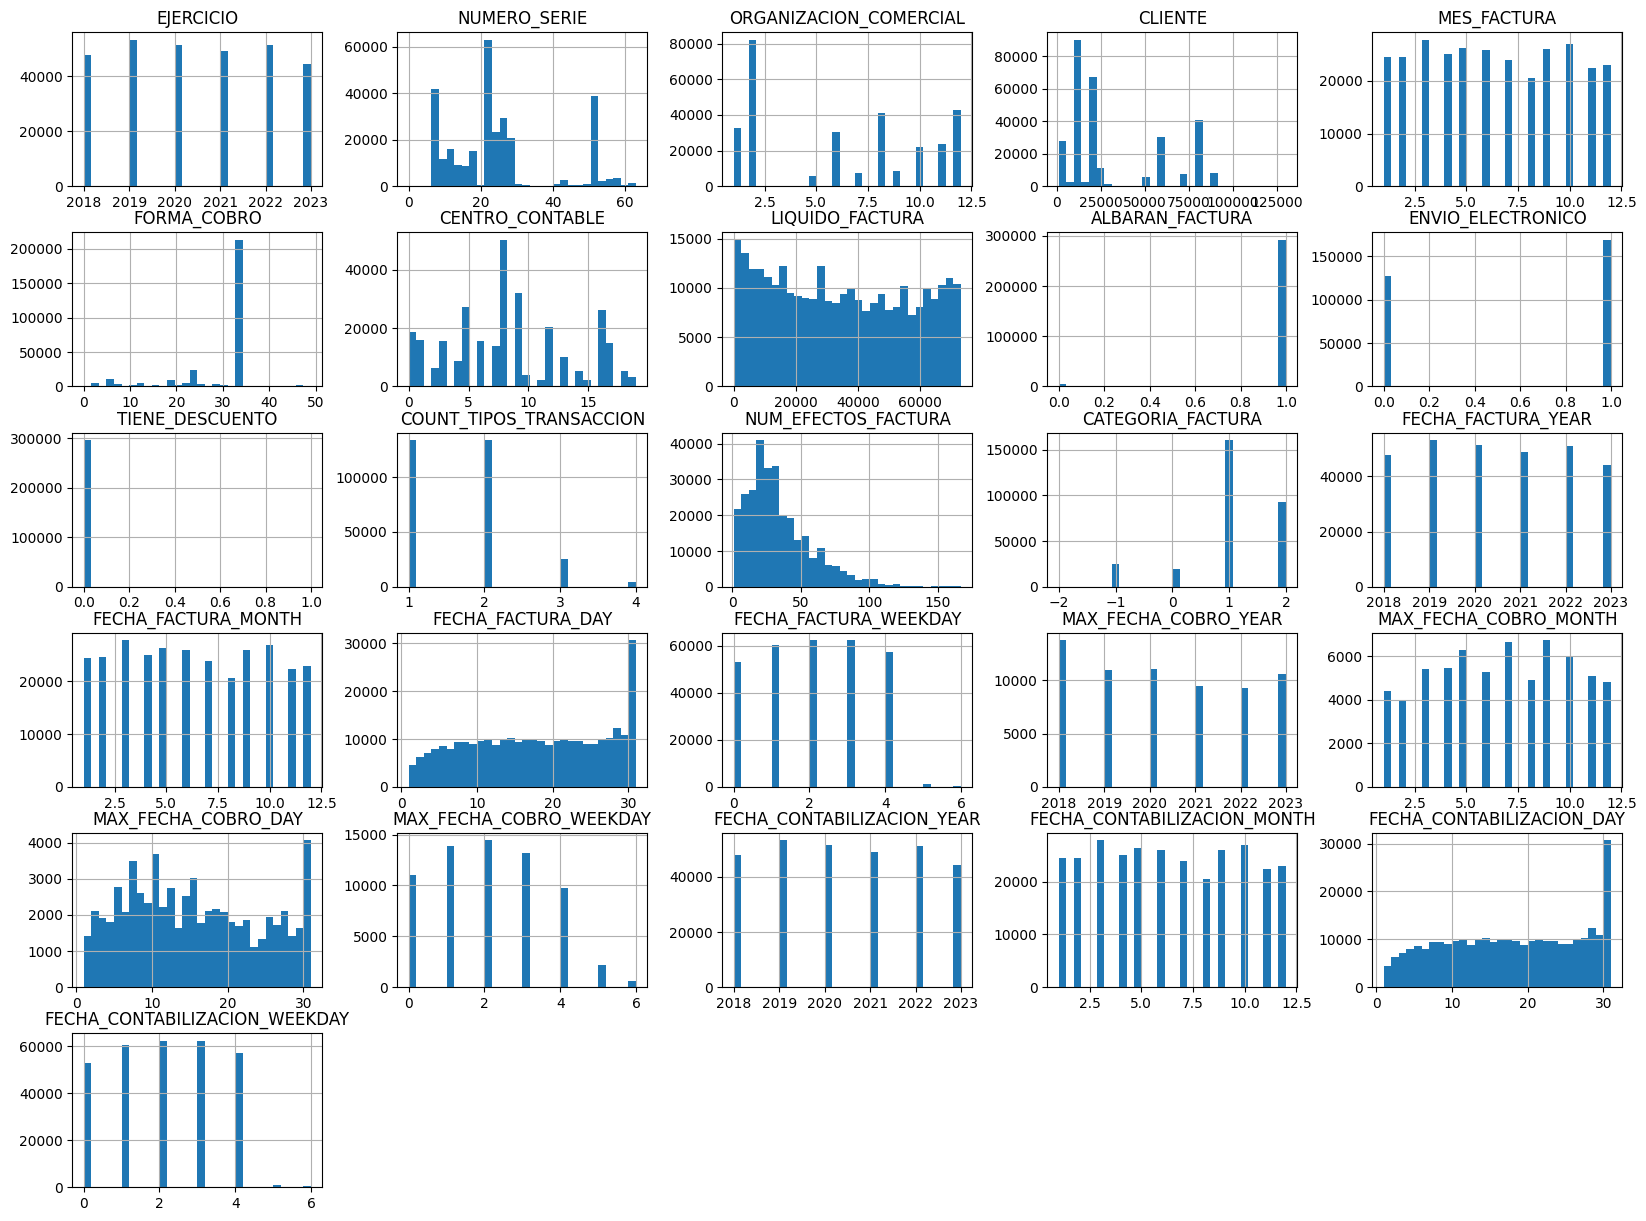

In [12]:

# Distribuciones de las características
data.hist(bins=30, figsize=(20, 15))
plt.show()


In [13]:

# Análisis de valores nulos
print("\nValores nulos en el dataset:")
data.isnull().sum()



Valores nulos en el dataset:


EJERCICIO                             0
NUMERO_SERIE                          0
ORGANIZACION_COMERCIAL                0
CLIENTE                               0
MES_FACTURA                           0
FORMA_COBRO                           0
CENTRO_CONTABLE                       0
LIQUIDO_FACTURA                       0
ALBARAN_FACTURA                       0
ENVIO_ELECTRONICO                     0
TIENE_DESCUENTO                       0
COUNT_TIPOS_TRANSACCION               0
NUM_EFECTOS_FACTURA                   0
CATEGORIA_FACTURA                     0
FECHA_FACTURA_YEAR                    0
FECHA_FACTURA_MONTH                   0
FECHA_FACTURA_DAY                     0
FECHA_FACTURA_WEEKDAY                 0
MAX_FECHA_COBRO_YEAR             231735
MAX_FECHA_COBRO_MONTH            231735
MAX_FECHA_COBRO_DAY              231735
MAX_FECHA_COBRO_WEEKDAY          231735
FECHA_CONTABILIZACION_YEAR            0
FECHA_CONTABILIZACION_MONTH           0
FECHA_CONTABILIZACION_DAY             0


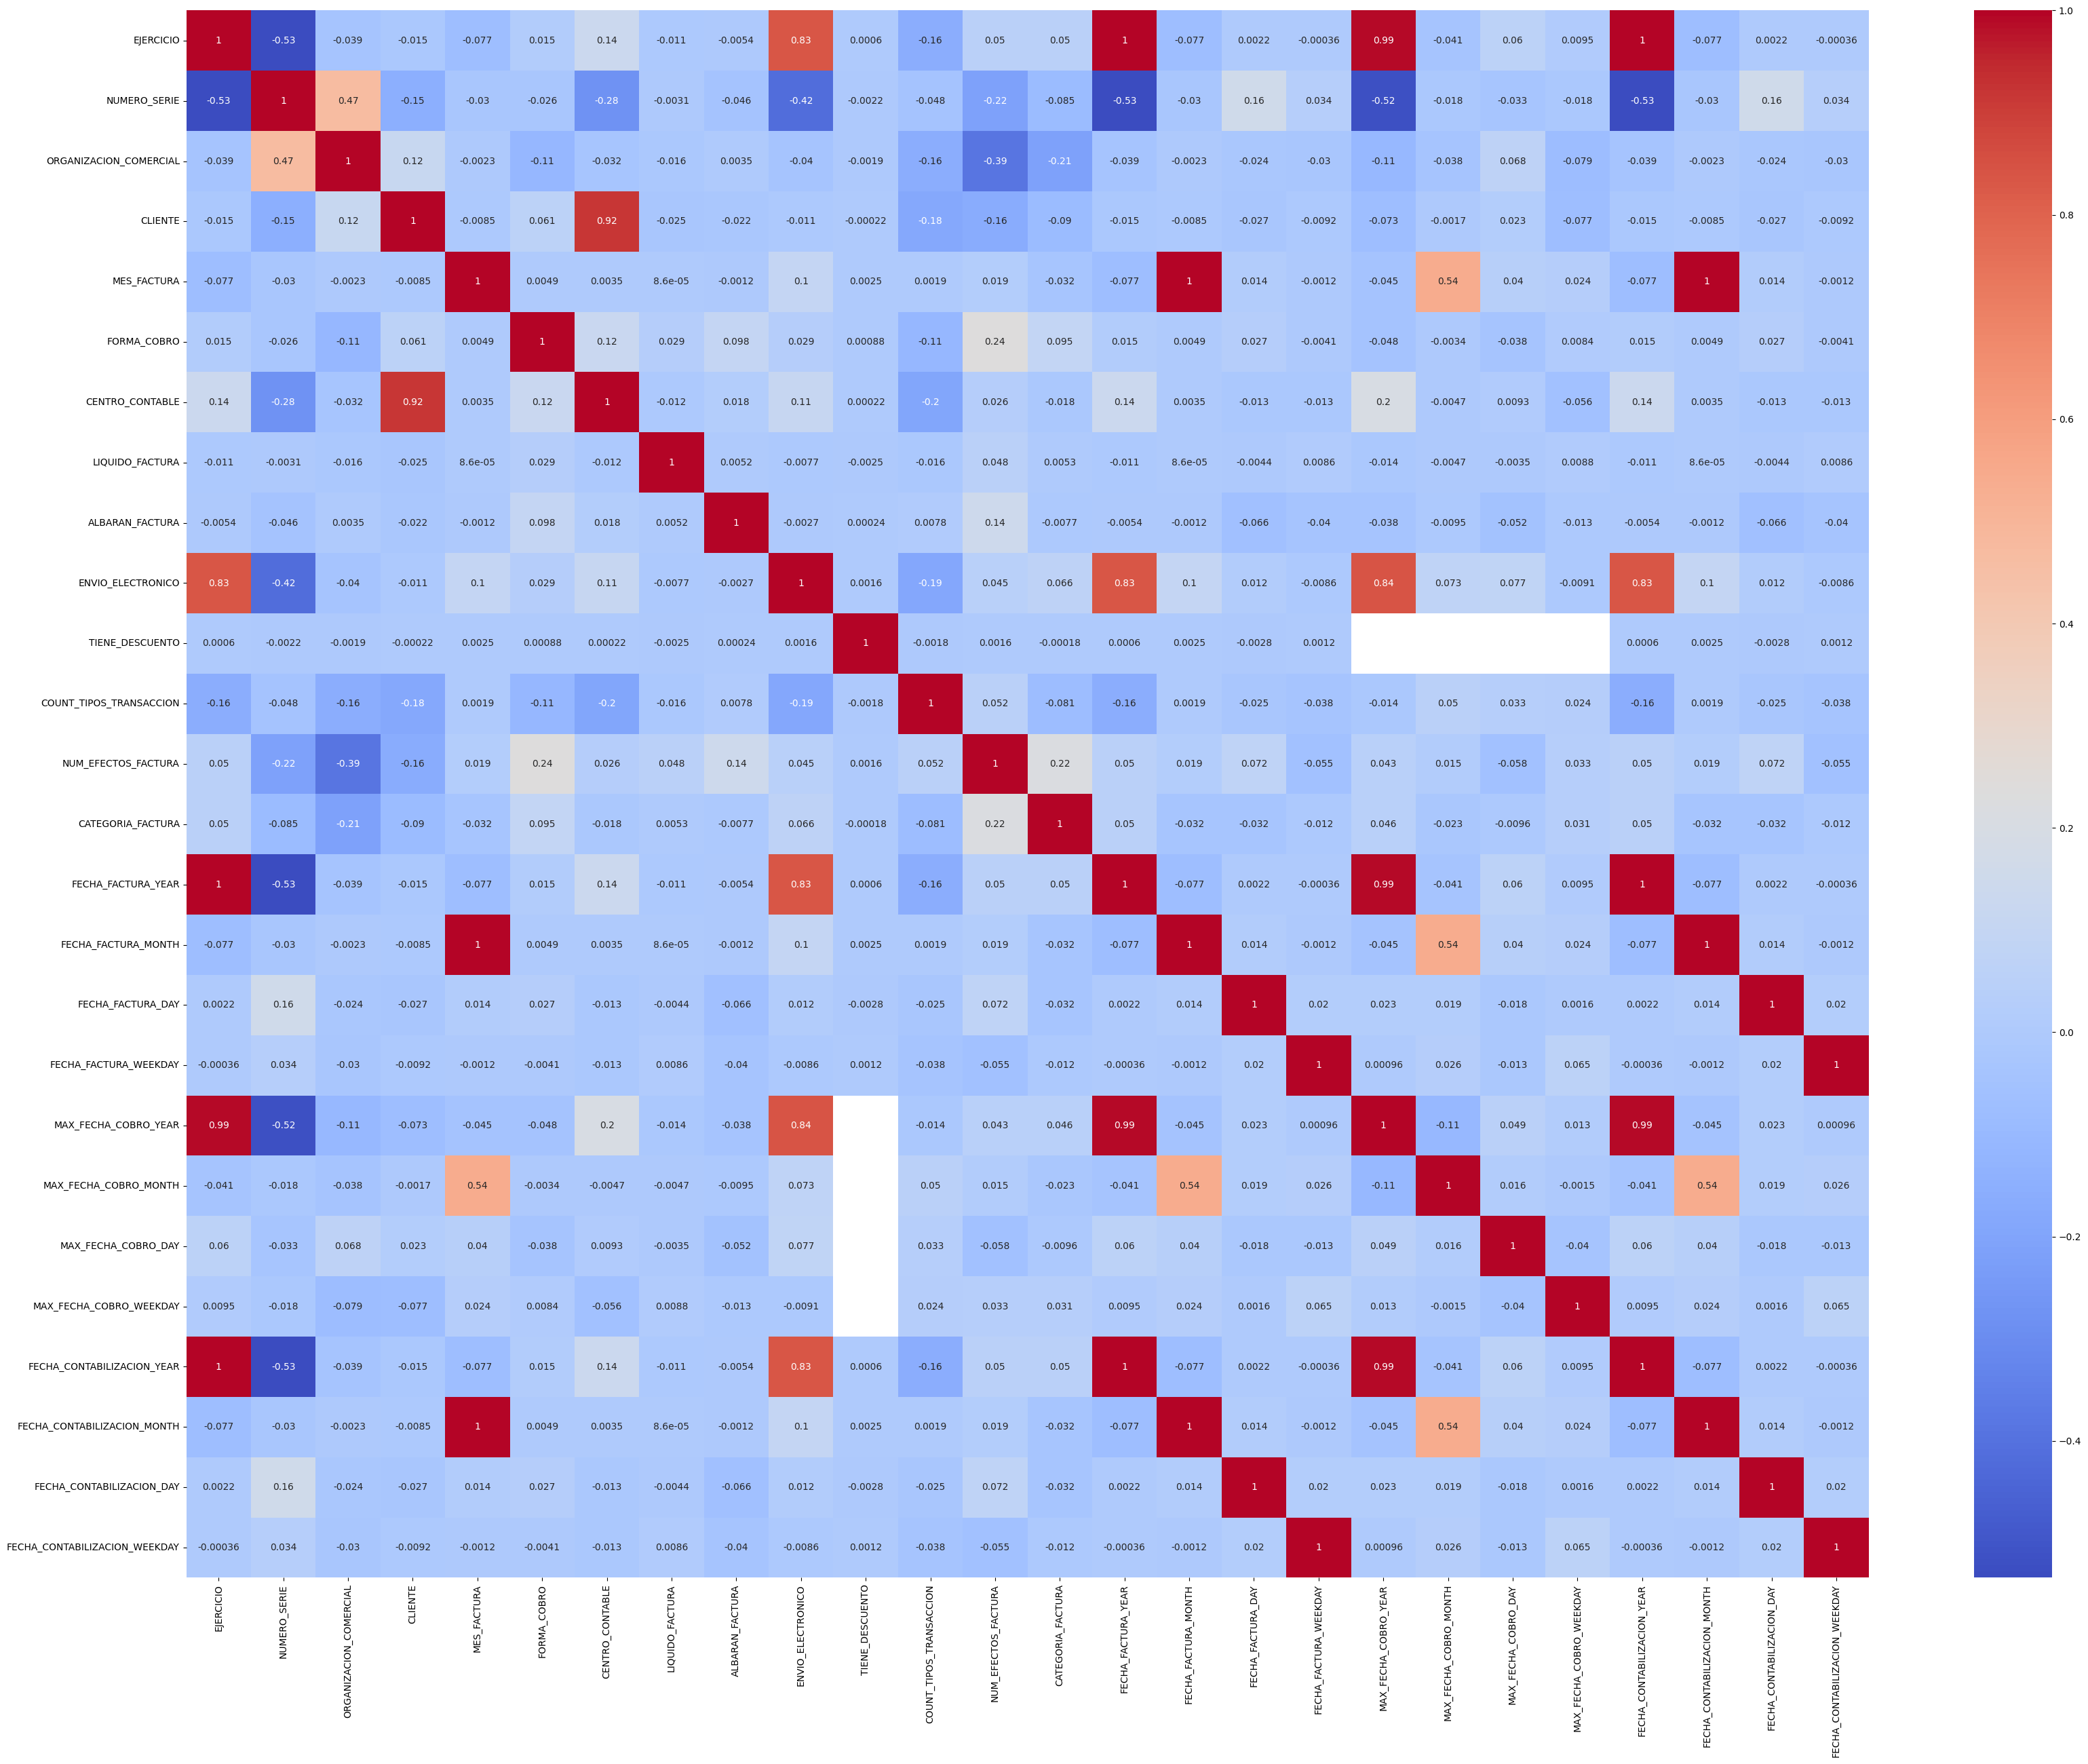

In [14]:
# Correlaciones entre las características
plt.figure(figsize=(40, 30))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:
# Manejo de valores nulos
data.fillna(data.mean(), inplace=True)

In [16]:
# Separación de características y variable objetivo
X = data.drop('CATEGORIA_FACTURA', axis=1)
#y = data['CATEGORIA_FACTURA']
# Re-codificar las clases de la variable objetivo
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(data['CATEGORIA_FACTURA'])

In [17]:

# División de los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:

# Estandarización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:

# Entrenamiento y Validación de Modelos de Clasificación

# Árboles de Decisión
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("\nÁrboles de Decisión:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))



Árboles de Decisión:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        12
           1       0.73      0.74      0.74      4786
           2       0.60      0.62      0.61      3849
           3       0.96      0.96      0.96     32126
           4       0.91      0.91      0.91     18592

    accuracy                           0.90     59365
   macro avg       0.82      0.83      0.83     59365
weighted avg       0.90      0.90      0.90     59365

[[   11     0     0     0     1]
 [    1  3556    91  1022   116]
 [    0    82  2386    27  1354]
 [    0  1126    50 30771   179]
 [    0   108  1460   152 16872]]


In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='gini', max_features='sqrt')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.82      0.77      0.79      4786
           2       0.67      0.62      0.65      3849
           3       0.97      0.98      0.97     32126
           4       0.92      0.93      0.93     18592

    accuracy                           0.92     59365
   macro avg       0.88      0.84      0.86     59365
weighted avg       0.92      0.92      0.92     59365

[[   11     1     0     0     0]
 [    0  3662    17  1078    29]
 [    0    56  2388    12  1393]
 [    0   677    13 31346    90]
 [    0    63  1132    42 17355]]


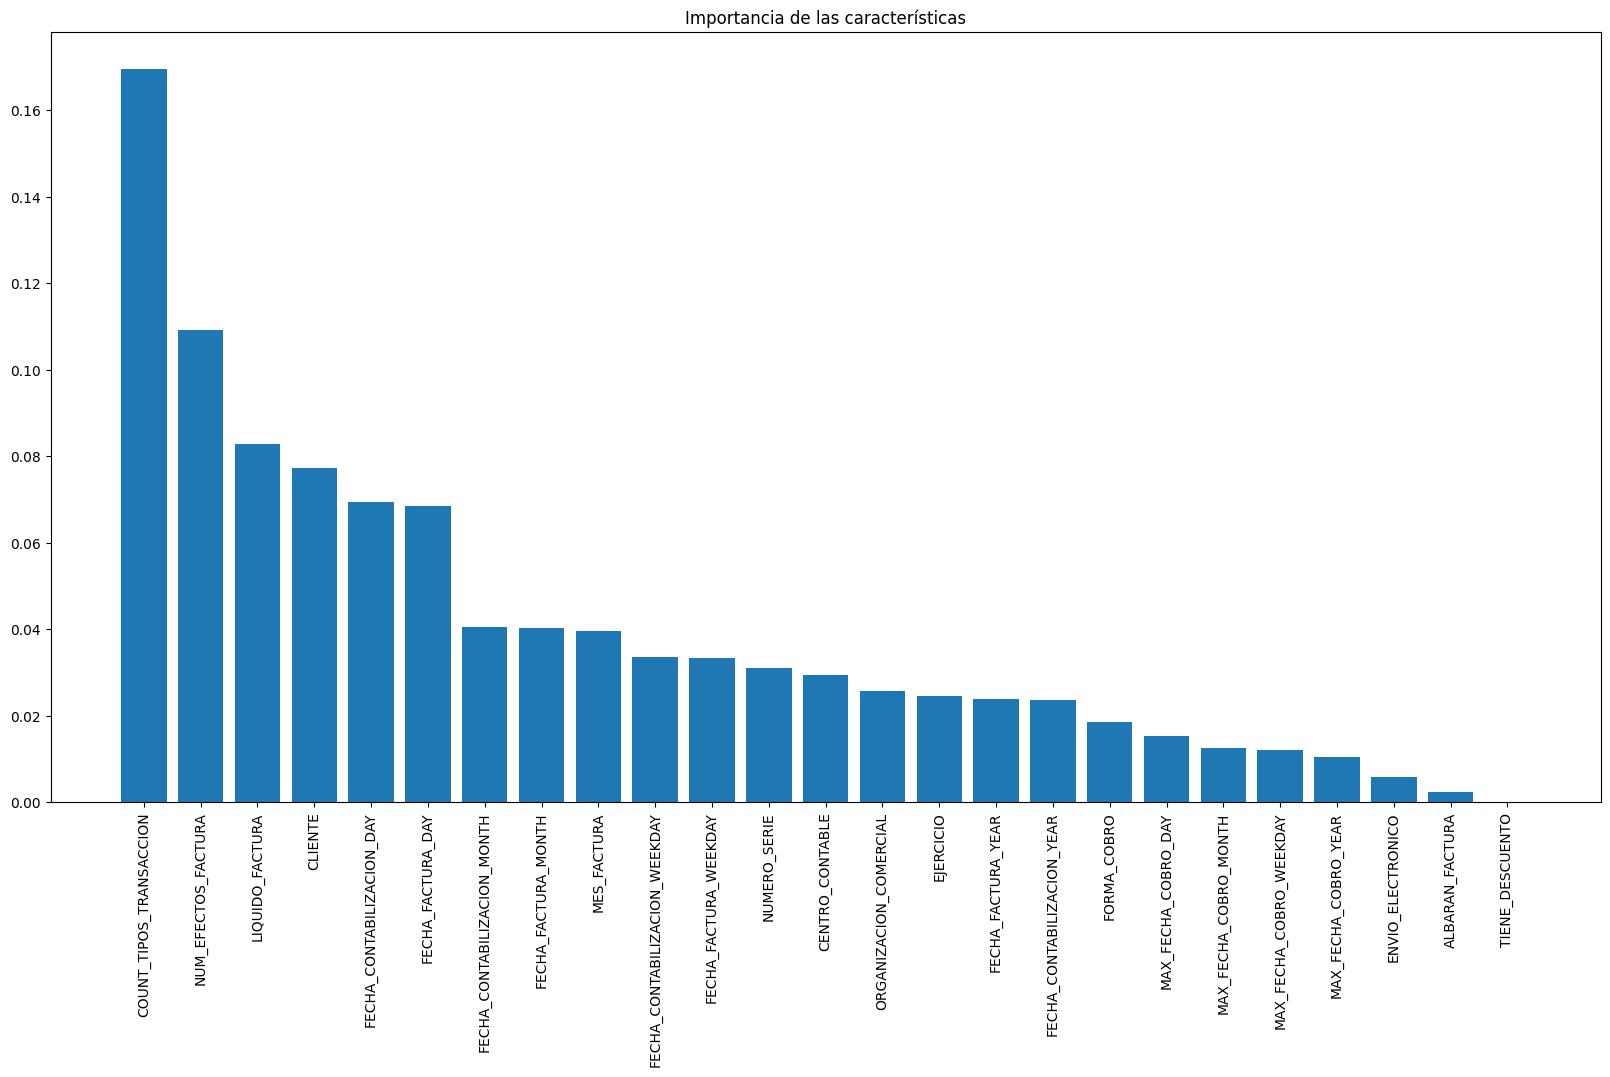

In [21]:
#revisamos la importancia de cada feature
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(20, 10))
plt.title("Importancia de las características")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.show()

In [22]:
# evaluamos el modelo random forest
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))

# evaluamos el sobreajuste
y_pred_train_rf = rf.predict(X_train)
print("Accuracy Train: ", accuracy_score(y_train, y_pred_train_rf))


Accuracy:  0.9224627305651478
Accuracy Train:  0.9999789435560965


In [23]:
# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("\nSupport Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


Support Vector Machine:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.57      0.40      0.47      4786
           2       0.65      0.03      0.06      3849
           3       0.84      0.88      0.86     32126
           4       0.68      0.81      0.74     18592

    accuracy                           0.77     59365
   macro avg       0.55      0.42      0.43     59365
weighted avg       0.76      0.77      0.74     59365

[[    0     4     0     6     2]
 [    0  1935     8  1779  1064]
 [    0   632   113   531  2573]
 [    0   290    13 28390  3433]
 [    0   512    40  3032 15008]]


/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bonay/.pyenv/versions/3.10.0/envs/gal_lua/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [26]:
# evaluamos el modelo random forest
print("Accuracy: ", accuracy_score(y_test, y_pred_svm))

Accuracy:  0.7655352480417754


In [27]:
# XGBoost
xgboost = xgb.XGBClassifier()
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)
print("\nXGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.65      0.49      0.56      4786
           2       0.64      0.24      0.35      3849
           3       0.90      0.94      0.92     32126
           4       0.79      0.88      0.83     18592

    accuracy                           0.84     59365
   macro avg       0.80      0.71      0.73     59365
weighted avg       0.83      0.84      0.82     59365

[[   12     0     0     0     0]
 [    0  2359   183  1554   690]
 [    0   550   942   339  2018]
 [    0   291    52 30044  1739]
 [    0   412   289  1527 16364]]


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
knn = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_knn = GridSearchCV(knn, param_grid_knn, refit=True, verbose=2)
grid_knn.fit(X_train, y_train)

print("\nMejores hiperparámetros para K-NN:")
print(grid_knn.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   5.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   5.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   5.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   6.8s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   7.9s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   6.6s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   6.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   6.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   6.4s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   6.3s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   6.5s
[CV] END ...metric=euclidean, n_neighbors=5, we

In [ ]:
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("\nK-NN:")
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))